In [5]:
import os
import sys
import urllib, io
import pickle

import numpy as np
import scipy.stats as stats
import pandas as pd
from sklearn.metrics import euclidean_distances, jaccard_score, pairwise_distances

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 
from IPython.core.display import HTML 

from io import BytesIO
import base64
import requests

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

sys.path.append("../../../stimuli/block_utils/")
sys.path.append("../")
import blockworld_utils as utils

In [342]:
experiment_name = 'recognition'

## directory & file hierarchy
proj_dir = os.path.abspath('../../..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')

# paths specific to this experiment
experiment_results_dir = os.path.join(results_dir, experiment_name)
# plot_dir = os.path.join(experiment_results_dir,'plots')
csv_dir = os.path.join(experiment_results_dir,'csv')
json_dir = os.path.join(experiment_results_dir,'json')

png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

In [343]:
plot_dir = results_dir + '/build_components/cogsci24/plots/'

In [344]:
import poster_plot_settings
from poster_plot_settings import palette

In [345]:
# which iteration name should we use?
iteration_name = 'build_components_pilot_2'

### Load csvs from dataframe generator

In [346]:
df_trial = pd.read_csv(csv_dir + '/df_trial_{}.csv'.format(iteration_name))

In [347]:
df_recog = df_trial[df_trial.trial_type == "block-tower-old-new"].reset_index().drop(columns=['index', 'Unnamed: 0'])

In [348]:
df_encode = df_trial[~(df_trial.trial_type == "block-tower-old-new")].reset_index().drop(columns=['index', 'Unnamed: 0'])

In [349]:
df_blocks = pd.read_csv(csv_dir + '/df_blocks_{}.csv'.format(iteration_name))

## Add useful columns

In [350]:
### Utils

def get_block_map(blocks):
    return utils.worldify(ast.literal_eval(blocks)).block_map[2:,0:4]

def mean_tower(group):
    return np.mean(group['square_map'])

### stimulus info

In [351]:
# import stim dataframes
df_towers = pd.read_csv('../../../stimuli/block_utils/ambiguous/ambiguous_composite_towers.csv')

In [352]:
df_towers['tower_id'] = df_towers.tower_id_tall

In [353]:
df_recog = df_recog.merge(df_towers[['tower_id','stim_wide']], on = 'tower_id')
df_recog['square_map'] = df_recog['stim_wide'].apply(lambda x: get_block_map(x))

#### export for stats

In [384]:
save = False

if save:
    filename = '../../../results/recognition/csv/df_recog_vss.csv'
    df_recog.to_csv(filename)
    print(filename)

../../../results/recognition/csv/df_recog_vss.csv


# Analysis 

### Analysis setup

### plot setup

In [356]:
# sns.set_context('poster')
# sns.set(font_scale=1.2)
# sns.set_style('whitegrid', {'font.family':'sans-serif', 'font.sans-serif':'Avenir'})

In [357]:
# Calculate 95% CI for each group
def calculate_ci(data, conf_level=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = sem * stats.t.ppf((1 + conf_level) / 2, len(data) - 1)
    return ci

## Key analyses

### Condition difference in accuracy

In [358]:
df_recog['novelty'] = ['new' if condition == 'foil' else 'old' for condition in df_recog.condition]

In [359]:
# double check accuracy calculations
df_recog['response_correct_recalc'] = ((df_recog.response_meaning == 'new') & (df_recog.condition == 'foil')) | \
                                       ((df_recog.response_meaning == 'old') & (df_recog.condition != 'foil'))

df_recog['response_correct_recalc'].equals(df_recog['response_correct'].astype(bool))

True

In [360]:
df_recog['responded_old'] = df_recog.response_meaning.apply(lambda x: 1 if x=='old' else 0)

In [361]:
df_recog.groupby('gameID')['response_correct'].mean().mean()

0.6683333333333333

(0.0, 1.0)

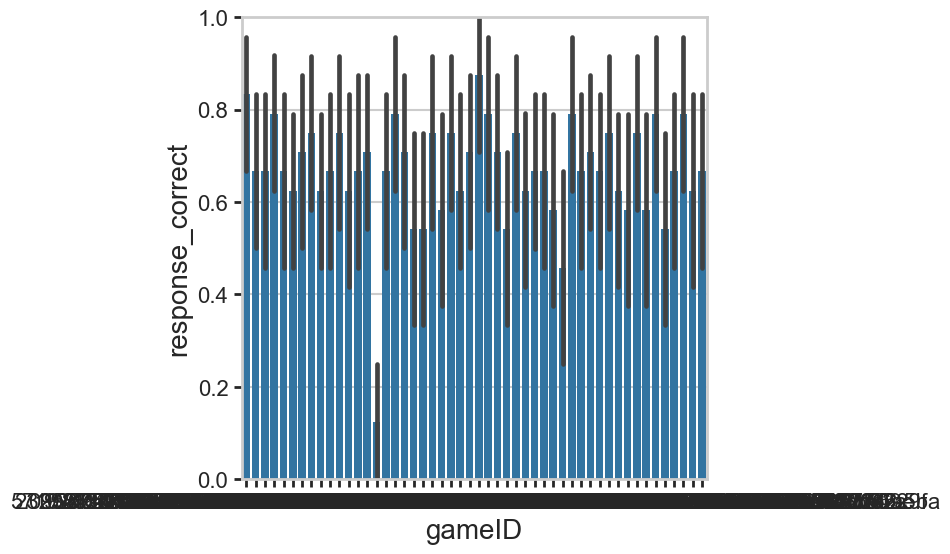

In [362]:
fig = plt.figure(figsize=(6,6))

sns.barplot(data = df_recog, 
            y = "response_correct",
            x = "gameID")
plt.ylim((0,1))

In [363]:
def parallel_bootstrap(df, 
                        bootstrap_column = 'gameID',
                        condition_column = 'condition',
                        value_columns = ['response_correct'],
                        n_iter = 1000,
                        seed = 0,
                        stat = np.mean):
    '''
    Bootstrap a distribution of means values for a given statistic while 
    keeping values of the bootstrapped column consistent across sample distributions.
    This can be used to e.g. sample the same participants in each iteration number.
    '''

    random.seed(seed)
    
    dists = {}
    empirical_stat = {}

    if condition_column != None:
        conditions = df[condition_column].unique()
    else:
        conditions = None

    grouped = df.groupby([bootstrap_column] + [condition_column])
    groups = df[bootstrap_column].unique()
    n_groups = df[bootstrap_column].nunique()

    grouped_stat = grouped[value_columns].apply(stat) 

    for condition in conditions:
        dists[condition] = []
        empirical_stat[condition] = np.mean(grouped_stat.loc[[(group, condition) for group in groups]])
        

    for i in range(n_iter):

        sample = random.choices(groups, k=n_groups)

        for condition in conditions:
            sample_values = grouped_stat.loc[[(group, condition) for group in sample]]
            sample_mean = np.mean(sample_values)
            dists[condition].append(sample_mean)

    
    return dists, empirical_stat

def bootstrap(df, bootstrap_column = 'gameID', condition_columns = ['condition'], value_columns = ['response'], n_iter = 1000, stat = np.mean):
    '''
    Bootstrap a distribution of means values for a given statistic.
    '''
    
    aggregate_values = [] # list of means of statistic for each sample


    df_build_dists_baseline_all = pd.DataFrame()
    grouped = df.groupby([bootstrap_column] + condition_columns)
    groups = df[bootstrap_column].unique()
    grouped_stat = grouped[value_columns].apply(stat) # apply statistic to each group 

    for i in range(n_iter):
        # sample groups to get list of statistics
        sample = grouped_stat.sample(n=grouped.ngroups, replace=True).reset_index(drop=True)
        
        aggregate_values.append(np.mean(sample))
    
    return aggregate_values

# Calculate 95% CI for each group
def create_ci(data, conf_level=0.95):
    mean = np.mean(data)
    sem = stats.sem(data)
    ci = sem * stats.t.ppf((1 + conf_level) / 2, len(data) - 1)
    
#     print('[{:.3g}, {:.3g}]'.format(mean - ci, mean + ci))
    
    return mean - ci, mean + ci

def bootstrapped_ci(data, conf_level=0.95):
    lower_bound = np.percentile(data, 100*(1-conf_level)/2)
    upper_bound = np.percentile(data, 100-100*(1-conf_level)/2)
    return lower_bound, upper_bound

def print_result(dist, empirical, conf_level=0.95):
    ci = bootstrapped_cis(dist, conf_level=conf_level)
    print('(${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(empirical, *ci))


def p_val(dist1, dist2):
    
    assert(len(dist1) == len(dist2))
    
    p = sum(np.array(dist1) < np.array(dist2)) / len(dist1)
    
    return p

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_49166/50491501.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_recog,


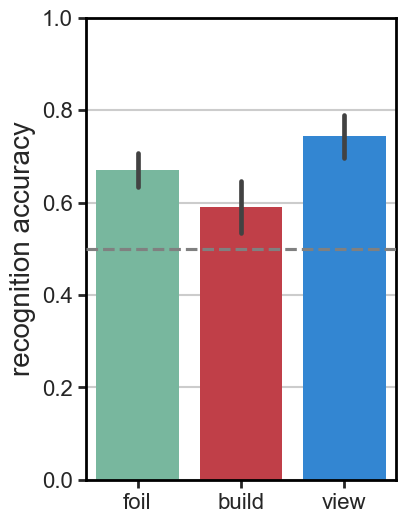

In [364]:
fig, ax = plt.subplots(figsize=(4,6))

# sem_foil = df_recog[df_recog["condition"] == "foil"]["response_correct"].sem()
# sem_build = df_recog[df_recog["condition"] == "build"]["response_correct"].sem()
# sem_view = df_recog[df_recog["condition"] == "view"]["response_correct"].sem()
# sem = [sem_foil, sem_build, sem_view]

# ci_foil  =  calculate_ci(df_recog[df_recog["condition"] == "foil"]["response_correct"])
# ci_build =  calculate_ci(df_recog[df_recog["condition"] == "build"]["response_correct"])
# ci_view  =  calculate_ci(df_recog[df_recog["condition"] == "view"]["response_correct"])
# ci = [ci_foil, ci_build, ci_view]

sns.barplot(data = df_recog, 
            y = "response_correct", 
            x = "condition",
            order = ['foil','build','view'],
#             errorbar=None,
#             errorbar=None,
#             yerr = ci,
            palette=palette)

plt.legend([],[], frameon=False)


plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)
plt.ylabel('recognition accuracy')
plt.xlabel('')

for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')
    
# plt.savefig('../../../results/build_components_cogscplots/recognition/plots/vis_rec_condition_accuracy.pdf', bbox_inches='tight')

plt.savefig(plot_dir + 'recog_acc.pdf', bbox_inches='tight')
plt.show()
# save the plot with the cut-off region included


In [365]:
# bootstrap individually

# rc_foil_boot = bootstrap(df_recog[df_recog.condition == 'foil'], 
#                       bootstrap_column = 'gameID', 
#                       value_columns = ['response_correct'], 
#                       n_iter = 1000)

# rc_view_boot = bootstrap(df_recog[df_recog.condition == 'view'], 
#                       bootstrap_column = 'gameID', 
#                       value_columns = ['response_correct'], 
#                       n_iter = 1000)

# rc_build_boot = bootstrap(df_recog[df_recog.condition == 'build'], 
#                       bootstrap_column = 'gameID', 
#                       value_columns = ['response_correct'], 
#                       n_iter = 1000)



# plt.figure()
# plt.hist(rc_foil_boot, alpha = 0.3)
# plt.hist(rc_view_boot, alpha = 0.3)
# plt.hist(rc_build_boot, alpha = 0.3)

In [366]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
accuracy_dists, accuracy_means = parallel_bootstrap(df_recog, 
                    bootstrap_column = 'gameID',
                    condition_column = 'condition',
                    value_columns = ['response_correct'],
                    n_iter = 1000,
                    stat = np.mean)

# OK potential issue here: I've found the means across participants, then found the difference between means. Rather than found the mean of differences. This means my p-value is coming out as 0, even when some people did have more correct responses to build than view. 

This might not be an issue. Maybe this was exactly what I intended. 'super participant'

(array([  1.,   0.,   8.,  31., 154., 275., 334., 146.,  44.,   7.]),
 array([0.42333333, 0.451     , 0.47866667, 0.50633333, 0.534     ,
        0.56166667, 0.58933333, 0.617     , 0.64466667, 0.67233333,
        0.7       ]),
 <BarContainer object of 10 artists>)

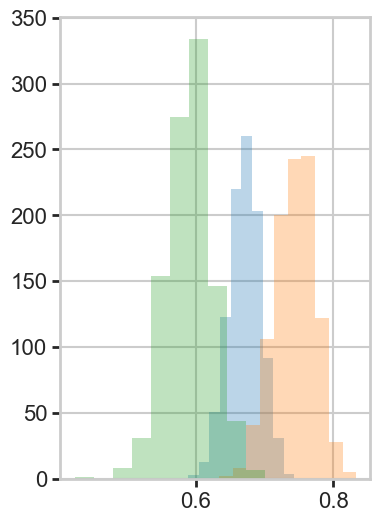

In [367]:
plt.figure()
plt.hist(accuracy_dists['foil'], alpha = 0.3)
plt.hist(accuracy_dists['view'], alpha = 0.3)
plt.hist(accuracy_dists['build'], alpha = 0.3)

In [368]:
print('foil ({:.3g}, 95\%\ CI: [{:.3g},\ {:.3g}])'.format(accuracy_means['foil'], *bootstrapped_ci(accuracy_dists['foil'])))
print('build ({:.3g}, 95\%\ CI: [{:.3g},\ {:.3g}])'.format(accuracy_means['build'], *bootstrapped_ci(accuracy_dists['build'])))
print('view ({:.3g}, 95\%\ CI: [{:.3g},\ {:.3g}])'.format(accuracy_means['view'], *bootstrapped_ci(accuracy_dists['view'])))


p_val(dists['view'], dists['build'])

# p_val(dists['view'], dists['build'])
# p_val(dists['foil'], dists['build'])
# p_val(dists['view'], dists['foil'])

foil (0.67, 95\%\ CI: [0.623,\ 0.717])
build (0.59, 95\%\ CI: [0.527,\ 0.653])
view (0.743, 95\%\ CI: [0.683,\ 0.793])


0.0

/var/folders/4y/_czpmr7d3gb8b80x7wh36g1c0000gn/T/ipykernel_49166/2647042876.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = df_recog,


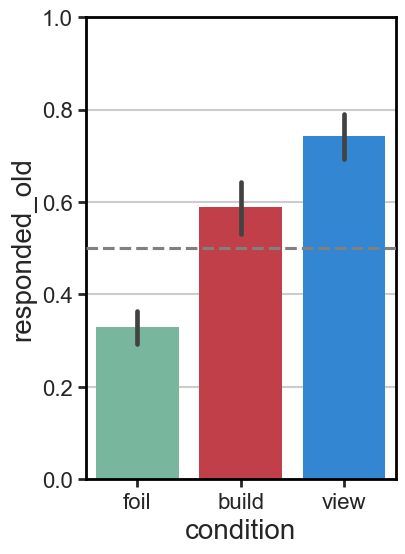

In [369]:
fig = plt.figure()
sns.barplot(data = df_recog, 
            y = "responded_old", 
            order = ['foil','build','view'],
            x = "condition",
            palette=palette)
plt.ylim((0,1))
plt.axhline(0.5, color = 'gray', linestyle = '--',)

for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')
    
plt.savefig(plot_dir + 'recog_response.pdf', bbox_inches='tight')

plt.show()

In [370]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
response_dists, response_means = parallel_bootstrap(df_recog, 
                    bootstrap_column = 'gameID',
                    condition_column = 'condition',
                    value_columns = ['responded_old'],
                    n_iter = 1000,
                    stat = np.mean)

(array([  1.,   0.,   8.,  31., 154., 275., 334., 146.,  44.,   7.]),
 array([0.42333333, 0.451     , 0.47866667, 0.50633333, 0.534     ,
        0.56166667, 0.58933333, 0.617     , 0.64466667, 0.67233333,
        0.7       ]),
 <BarContainer object of 10 artists>)

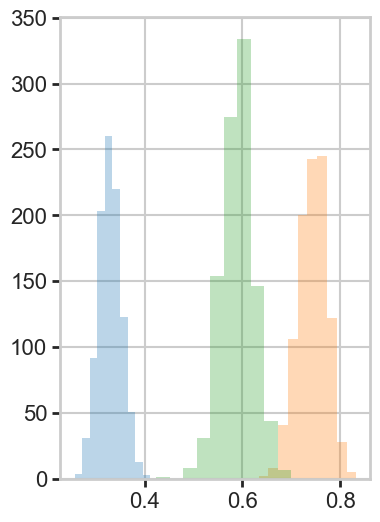

In [371]:
plt.figure()
plt.hist(response_dists['foil'], alpha = 0.3)
plt.hist(response_dists['view'], alpha = 0.3)
plt.hist(response_dists['build'], alpha = 0.3)

In [372]:
print('foil (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means['foil'], *bootstrapped_ci(response_dists['foil'])))
print('build (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means['build'], *bootstrapped_ci(response_dists['build'])))
print('view (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means['view'], *bootstrapped_ci(response_dists['view'])))


# p_val(dists['view'], dists['build'])

print(p_val(response_dists['view'], response_dists['build']))
print(p_val(response_dists['build'], response_dists['foil']))
print(p_val(response_dists['view'], response_dists['foil']))

foil ($0.33,\ 95\%\ CI: [0.283,\ 0.377]$)
build ($0.59,\ 95\%\ CI: [0.527,\ 0.653]$)
view ($0.743,\ 95\%\ CI: [0.683,\ 0.793]$)
0.0
0.0
0.0


In [373]:
# split into old and new stimuli

In [374]:
# bootstrap keeping participants' data together (i.e. sampled ppt n is the same across all distributions)
response_dists_novelty, response_means_novelty = parallel_bootstrap(df_recog, 
                    bootstrap_column = 'gameID',
                    condition_column = 'novelty',
                    value_columns = ['responded_old'],
                    n_iter = 1000,
                    stat = np.mean)

In [375]:
print('old (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means_novelty['old'], *bootstrapped_ci(response_dists_novelty['old'])))
print('new (${:.3g},\ 95\%\ CI: [{:.3g},\ {:.3g}]$)'.format(response_means_novelty['new'], *bootstrapped_ci(response_dists_novelty['new'])))


# p_val(dists['view'], dists['build'])

print(p_val(response_dists_novelty['old'], response_dists_novelty['new']))

old ($0.667,\ 95\%\ CI: [0.62,\ 0.708]$)
new ($0.33,\ 95\%\ CI: [0.283,\ 0.377]$)
0.0


In [376]:
df_recog.novelty

0       new
1       old
2       old
3       new
4       new
       ... 
1195    old
1196    old
1197    new
1198    new
1199    new
Name: novelty, Length: 1200, dtype: object

<Axes: xlabel='gameID', ylabel='response_correct'>

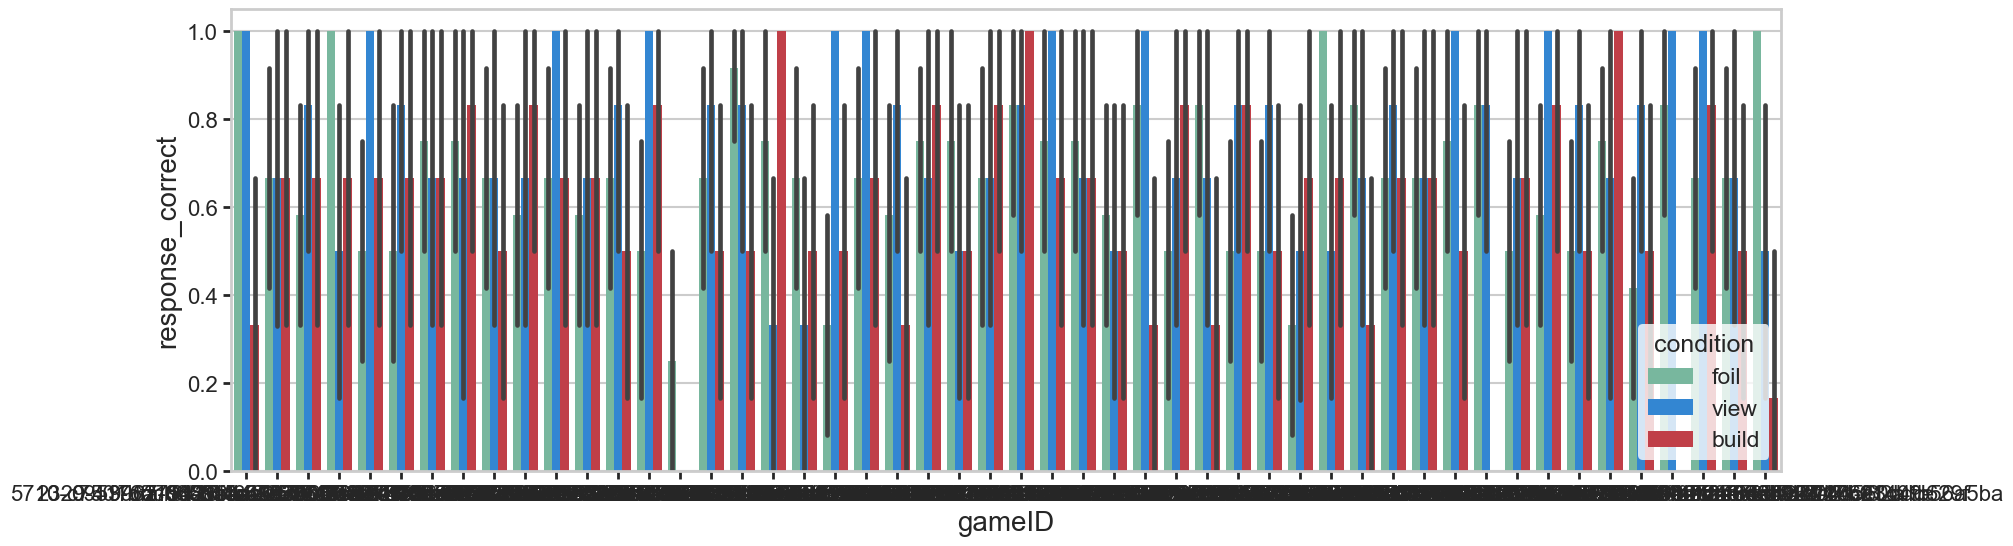

In [377]:
fig = plt.figure(figsize=(20,6))

sns.barplot(data = df_recog, 
            y = "response_correct", 
            x = "gameID",
            hue = "condition",
            palette=palette)

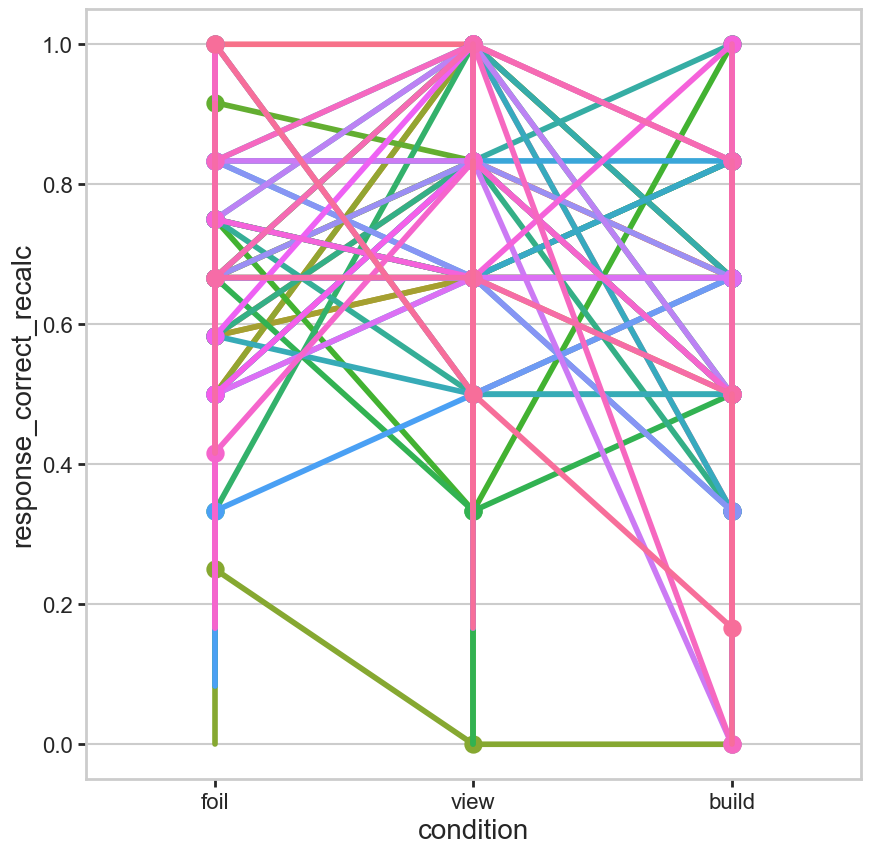

In [378]:
fig = plt.figure(figsize=(10,10))

sns.pointplot(data = df_recog, 
            y = "response_correct_recalc", 
            x = "condition",
            hue="gameID")
# plt.legend(bbox_to_anchor=(1,1))
plt.legend([],[], frameon=False)


In [379]:
# visualize all responses
# df_recog.groupby('gameID').response.apply(lambda g : ''.join([x for x in g]))

### Condition difference in d'

hit rate H: proportion of YES trials to which subject responded YES =  P("yes" | YES)
false alarm rate F: proportion of NO trials to which subject responded YES  = P("yes" | NO)
d' = z(H) - z(F)


comparing d' for build and view conditions.
In each of these we can look at the hit rate.
But the false alarm rate isn't tied to the hit rate (i.e. false alarms don't have a condition).\


For each participant, for each condition:
- Hit: number of old trials to which ppt responded *old*
- Miss: number of old trials to which ppt responded *new*
- False alarm: number of new trials to which ppt responded *old*
- Correct rejection: number of new trials to which ppt responded *new*

In [380]:
def detection_measures(df_group):
    olds = df_group[df_group.novelty == 'old']
    news = df_group[df_group.novelty == 'new']
    
    # raw counts
    n_hit = len(olds[olds['response_meaning'] == 'old'])
    n_miss = len(olds[olds['response_meaning'] == 'new'])
    n_false_alarm = len(news[news['response_meaning'] == 'old'])
    n_correct_reject = len(news[news['response_meaning'] == 'new'])
    
    return pd.Series({'n_hit': n_hit,
            'n_miss' : n_miss,
            'n_false_alarm' : n_false_alarm,
            'n_correct_reject' : n_correct_reject,
            'n_old_trials' : len(olds),
            'n_new_trials': len(news)
           })

In [381]:
view_measures = df_recog[df_recog.condition.isin(['view','foil'])].groupby(['gameID']).apply(detection_measures)
build_measures = df_recog[df_recog.condition.isin(['build','foil'])].groupby(['gameID']).apply(detection_measures)

view_measures['condition'] = 'view'
build_measures['condition'] = 'build'

view_measures = view_measures.reset_index()
build_measures = build_measures.reset_index()

In [382]:
condition_measures = view_measures.append(build_measures, ignore_index=True)

AttributeError: 'DataFrame' object has no attribute 'append'

In [ ]:
condition_measures

In [ ]:
from scipy.stats import norm

Z = norm.ppf

In [ ]:
def old_new_d_prime(df):
    '''
    Old trials are 'yes' trials. As in 'yes I remember this'.

    For this design, F will be the same for both conditions (build and view).
    '''
    H = df['n_hit'] / df['n_old_trials']
    
    # replace HIT rates to avoid inf d-prime
    if H == 1: 
        H = 0.9999
    if H == 0:
        H = 0.0001
    
    
    F = df['n_false_alarm'] / df['n_new_trials'] 
    
    # replace FA rates to avoid inf d-prime
    if F == 1: 
        F = 0.9999
    if F == 0: 
        F = 0.0001
    
    d_prime = Z(H) - Z(F)
    
    return d_prime

In [ ]:
condition_measures['d_prime'] = condition_measures.apply(lambda row: old_new_d_prime(row), axis=1)

In [ ]:
fig = plt.figure(figsize=(4/(3/2),6))

# sem_build = condition_measures[condition_measures["condition"] == "build"]["d_prime"].sem()
# sem_view = condition_measures[condition_measures["condition"] == "view"]["d_prime"].sem()
# sem = [sem_build, sem_view]

ci_build =  calculate_ci(condition_measures[condition_measures["condition"] == "build"]["d_prime"])
ci_view =  calculate_ci(condition_measures[condition_measures["condition"] == "view"]["d_prime"])
ci = [ci_build, ci_view]

sns.barplot(data = condition_measures, 
            y = "d_prime", 
            x = "condition",
            order = ['build', 'view'],
            errorbar=None,
            yerr = ci,
            palette=palette)

plt.ylabel('d\'')
plt.ylim((0,2.5))
plt.xlabel('')


# sns.lineplot(data = condition_measures,
#              y = "d_prime",
#              x = "condition",
#              hue = "gameID",
#              palette=["#222"],
#              alpha=0.5,
#              linewidth=1,
# #              ax=ax,
# #              errorbar=None
#             )



plt.legend([],[], frameon=False)

for spine in fig.gca().spines.values():
    spine.set_zorder(1)
    spine.set_color('black')

fig.savefig('../results/build_components/plots/vis_rec_condition_d_prime.pdf', bbox_inches='tight')

In [ ]:
condition_measures.groupby('condition')['d_prime'].mean()

In [ ]:
fig = plt.figure(figsize=(10,10))

sns.pointplot(data = condition_measures, 
            y = "d_prime", 
            x = "condition",
            hue = "gameID")

plt.legend([],[], frameon=False)

### Effect of tower

In [ ]:
def show_tower(url, ax):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
#     plt.figure(figsize=(2,1))
    ax.imshow(img)
    ax.axis('off')
    
def show_tower_subplot(tower_id,
                      ax,
              url_stem = "https://zipping-composites-monochrome-png-rerender.s3.amazonaws.com/tower_4_block_unique_silhouettes_composites_monochrome_png_rerender_{}.png"):
    
    response = requests.get(url_stem.format(tower_id))
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(tower_id)
    

In [ ]:
tower_ids = list(np.sort(df_recog.tower_id.unique()))

In [ ]:
plt.figure(figsize = (10,10))
sns.pointplot(data = df_recog[df_recog.condition != 'foil'],
            y = 'response_correct',
            x = 'condition',
            hue = 'tower_id',
            hue_order=tower_ids)
# plt.xticks(rotation = 45)
plt.legend(bbox_to_anchor = (1,1))

plt.title('')

In [ ]:
plt.figure(figsize = (20,6))
sns.barplot(data = df_recog[df_recog.condition != 'foil'],
            y = 'response_correct',
            x = 'tower_id',
#             hue = 'condition',
            order=tower_ids)
plt.xticks(rotation = 90)
plt.legend(bbox_to_anchor = (1,1))

In [ ]:
n_row = 3
fig, axs = plt.subplots(n_row, int(len(tower_ids)/n_row), figsize=(20,6))

for i, tower in enumerate(tower_ids):
    show_tower_subplot(tower, axs[int(np.floor(i/(len(tower_ids)/n_row))), i%(int(len(tower_ids)/n_row))])

## Building measures

#### Build time

relative_time: time between start and end of building trial. This includes *all* attempts, i.e. time including resets.

In [ ]:
parallel_bootstrap?

In [ ]:
df_encode.loc[:,'relative_time_s'] = df_encode.relative_time / 1000

In [ ]:
time_dist, mean_time =  parallel_bootstrap(df_encode[df_encode.condition == 'build'],
                   condition_column='condition',
                   value_columns=['relative_time_s']
                  )

In [ ]:
print_result(time_dist['build'], mean_time['build'])

In [ ]:
# df_build['trial_num'] = df_build.trial_index - 3
# df_build['trial_num']

# build_start = df_build[df_build.trial_num == 0][['gameID','trial_start_time']]
# build_start = build_start.rename(columns = {'trial_start_time': 'build_start_time'})

# build_finish = df_build[df_build.trial_num == 15][['gameID','timeAbsolute']]
# build_finish = build_finish.rename(columns= {'timeAbsolute':'build_finish_time'})
# build_timing = build_start.merge(build_finish, on='gameID')
# build_timing['build_duration'] = build_timing['build_finish_time'] - build_timing['build_start_time']
# build_timing['build_duration_min'] = build_timing['build_duration'] / (1000 * 60)
# build_timing

In [ ]:
df_build = df_encode[df_encode.trial_type == 'block-tower-building']

In [ ]:
build_times = df_build.groupby('gameID')[['relative_time']].mean().reset_index()

In [ ]:
plt.figure(figsize =(10,6))

sns.barplot(data = df_build,
            x = 'gameID',
            y = 'relative_time',
            )

In [ ]:
sns.histplot(build_times,
            x = 'relative_time',
            log_scale=False,
            bins=10)

In [ ]:
build_times.mean()

Average build time is a lot longer than the 15 seconds people have to view the structure. 

### Resets

In [ ]:
reset_means = df_build.groupby('gameID')[['n_resets']].mean().reset_index()

In [ ]:
# raw trials
sns.histplot(df_build,
            x = 'n_resets',
            log_scale=False,
            bins=10)

In [ ]:
# mean for ppts
sns.histplot(reset_means,
            x = 'n_resets',
            log_scale=False,
            bins=10)

## Time measures

These plots seem to suggest that the longer you wait between encoding and recall, the worse your memory of that item.

In [ ]:
# this dataframe contains recognition trials only from targets (i.e. non-foils)
# it is augmented with additional variables from here onwards
df_recog_target = df_recog[df_recog.condition != 'foil']

#### Encoding trial number

Were the targets that were viewed/ built later remembered better?
Looks like that may be the case.
Also looks like a slight primacy bias?

In [ ]:
df_encode['encode_trial_num'] = df_encode.trial_num

In [ ]:
df_recog_target = df_recog_target.merge(df_encode[df_encode.condition != 'foil']\
                                        [['gameID', 'tower_id','encode_trial_num']], 
                                        on = ['gameID','tower_id'])

In [ ]:
sns.lineplot(data = df_recog_target,
                x = 'encode_trial_num',
                y = 'response_correct')
plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Recog trial number

Were the targets that were probed earlier remembered better?

In [ ]:
df_recog['recog_trial_num'] = df_recog.trial_num - 12
df_recog_target['recog_trial_num'] = df_recog_target.trial_num - 12

In [ ]:
sns.lineplot(data = df_recog,
                x = 'recog_trial_num',
                y = 'response_correct')
plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Number of trials between encoding and recognition

Were the targets with a smaller gap (number of trials) between encoding and recognition better remembered?

Eyeballing this graph it does look like the longer between encoding and recognition trials, the worse the performance.

In [ ]:
def trial_diff(df, col='trial_num'):
    return df[col].max() - df[col].min()

In [ ]:
trial_diffs = df_trial[df_trial.condition != 'foil'].groupby(['gameID','tower_id']).apply(trial_diff).reset_index()

In [ ]:
trial_diffs = trial_diffs.rename(columns = {0: 'trial_diff'})

In [ ]:
df_recog_target = df_recog_target.merge(trial_diffs, on=['gameID','tower_id'])

In [ ]:
sns.lineplot(data = df_recog_target,
                x = 'trial_diff',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

#### Duration between encoding and recognition

Were the targets with a smaller gap (absolute time) between encoding and recognition better remembered?

In [ ]:
trial_time_diffs = df_trial[df_trial.condition != 'foil']\
    .groupby(['gameID','tower_id']).apply(lambda group: trial_diff(group, col='trial_start_time')).reset_index()

In [ ]:
trial_time_diffs = trial_time_diffs.rename(columns = {0: 'trial_time_diff'})

In [ ]:
df_recog_target = df_recog_target.merge(trial_time_diffs, on=['gameID','tower_id'])

In [ ]:
df_recog_target['trial_time_diff_bin'] = pd.cut(df_recog_target.trial_time_diff, 10)

In [ ]:
plt.figure(figsize=(10,6))

sns.barplot(data = df_recog_target,
                x = 'trial_time_diff_bin',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

In [ ]:
df_recog_target['trial_log_time_diff_bin'] = pd.cut(np.log(df_recog_target.trial_time_diff), 10)

In [ ]:
plt.figure(figsize=(10,6))

sns.barplot(data = df_recog_target,
                x = 'trial_log_time_diff_bin',
                y = 'response_correct')

plt.axhline(0.5, color = 'r', linestyle = '--',)

### Check for reasonable distribution of temporal differences between conditions

In [ ]:
df_condition_means = df_recog_target.groupby(['gameID','condition']).mean().reset_index()

In [ ]:
sns.pointplot(data = df_recog_target,
            x = 'condition',
            y = 'trial_diff',
            hue = 'gameID')
plt.legend([],[], frameon=False)

In [ ]:
sns.pointplot(data = df_recog_target,
            x = 'condition',
            y = 'trial_time_diff',
            hue = 'gameID')
plt.legend([],[], frameon=False)

In [ ]:
def condition_diff(df, cols = ['d_prime']):
    '''
    Returns difference between build and view conditions for variables in cols
    '''
#     print(df.condition)
    
    diffs = df[df.condition=='view'][cols].iloc[0] - df[df.condition=='build'][cols].iloc[0] 
    
    
    diffs = diffs.rename({col : col + '_diff' for col in cols})
    
    return diffs

In [ ]:
# used below as predictor of d' differences
condition_time_diffs = df_condition_means.groupby(['gameID']).apply(lambda df: condition_diff(df, cols = ['trial_diff',
                                                                                   'recog_trial_num' ,
                                                                                   'encode_trial_num',
                                                                                   'trial_time_diff']))

## Properties of stimuli/ kinds of errors

### Holistic measures of similarity

In [ ]:
### Measures

def jaccard_distance(a, b):
    return 1 - jaccard_score(a, b, average = 'micro')

def euclidean_distance(a, b):
    return math.dist(a.flatten(), b.flatten())

def euc_2(a, b):
    return np.linalg.norm(a-b)


### Calculate variabilities

def between_group_var(group_a, group_b, metric = euc_2):
    
    both_groups = group_a.copy().append(group_b.copy(), ignore_index = True)
    
    y_bar = mean_tower(both_groups)
    
    group_a_mean = mean_tower(group_a)
    group_b_mean = mean_tower(group_b)
    
    inside_sum = [(len(group_a) * ((metric(group_a_mean, y_bar))**2)), (len(group_b) * ((metric(group_b_mean, y_bar))**2))]
    
#     distances = np.array([[jaccard_distance(tower_a, tower_b) for tower_b in group_a['square_map']] for tower_a in group_b['square_map']])
    
#     squared_distances = np.square(distances)

    var = np.sum(inside_sum)
    
    return var
    

def within_group_var(group_a, group_b, metric = euc_2):
    '''
    Calculates variance using errors i.e. distances from the mean,
    where mean is literally the pointwise mean the map of blocks
    
    e.g. mean of these
    [[0, 0, 0, 0],      [[0, 0, 0, 0],
     [0, 1, 1, 0],       [0, 0, 0, 0],
     [0, 1, 1, 0],       [0, 1, 1, 1],
     [0, 1, 1, 0]]       [0, 1, 1, 1]] 

    is:
    [[0, 0, 0, 0],
     [0,.5,.5, 0],
     [0, 1, 1,.5],
     [0, 1, 1,.5]]
     
    This means we can't use jaccard or any other measure of similarity that requires discrete values.
    '''
    
    total_observations = len(group_a) + len(group_b)
    
    group_vars = []
    
    for group in [group_a, group_b]:
        
        group_mean = mean_tower(group)

        errors = group['square_map'].apply(lambda tower: metric(tower, group_mean))
        
        sqrd_errors = np.square(errors)

        sum_sqrd_errors = np.sum(sqrd_errors)
        
        group_var = sum_sqrd_errors/(total_observations - 2) # 2 is number of groups
        
        group_vars.append(group_var)
    
    sum_vars = sum(group_vars)
    
    return sum_vars


def get_variabilities(df, metric = euc_2):
    
    # group contains recall trials from a single ppt
    
    build_group = df[df.condition == 'build']
    view_group  = df[df.condition == 'view']
    foil_group  = df[df.condition == 'foil']
    
    group_variabilities = {
        'build_between_group_var' : between_group_var(build_group, foil_group, metric = metric),
        'build_within_group_var' : within_group_var(build_group, foil_group, metric = metric),
        'view_between_group_var'  : between_group_var(view_group, foil_group, metric = metric),
        'view_within_group_var'  : within_group_var(view_group, foil_group, metric = metric),
    }
    
    group_variabilities['build_f_ratio'] = group_variabilities['build_between_group_var'] / group_variabilities['build_within_group_var']
    group_variabilities['view_f_ratio'] = group_variabilities['view_between_group_var'] / group_variabilities['view_within_group_var']
    
    return pd.Series(group_variabilities)

#### Euclidean Distance

In [ ]:
df_variabilities = df_recog.groupby(['gameID']).apply(\
                        lambda group : get_variabilities (group, metric = euc_2)).reset_index()     

In [ ]:
# tidy dataframe
build_variabilities = df_variabilities[['build_between_group_var','build_within_group_var','build_f_ratio','gameID']].copy()
build_variabilities['condition'] = 'build'
view_variabilities = df_variabilities[['view_between_group_var','view_within_group_var','view_f_ratio','gameID']].copy()
view_variabilities['condition'] = 'view'

build_variabilities = build_variabilities.rename(columns = {'build_between_group_var': 'between_group_var',
                                      'build_within_group_var': 'within_group_var',
                                      'build_f_ratio': 'f_ratio'})

view_variabilities = view_variabilities.rename(columns = {'view_between_group_var': 'between_group_var',
                                     'view_within_group_var': 'within_group_var',
                                     'view_f_ratio': 'f_ratio'})

df_variabilities_tidy = build_variabilities.append(view_variabilities, ignore_index=True)
df_variabilities_tidy['measure'] = 'euclidean'
df_variabilities_tidy

### Export condition measures csvs

In [ ]:
condition_measures_expanded = condition_measures.copy().merge(df_variabilities_tidy, on = ['gameID','condition'])

In [ ]:
condition_measures_expanded.to_csv('../../results/build_components/csv/df_condition_measures_{}.csv'.format(iteration_name))

In [ ]:
# df_recog.to_csv('../../results/build_components/csv/df_recog_{}.csv'.format(iteration_name))

In [ ]:
sns.scatterplot(
    data = condition_measures_expanded,
    x = 'f_ratio',
    y = 'd_prime',
    hue = 'condition'
)

#### Jaccard similarity

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.jaccard_score.html

In [ ]:
# You cannot calculate the Jaccard score between continuous variables

# df_variabilities = df_recog.groupby(['gameID']).apply(\
#                         lambda group : get_variabilities (group, metric = jaccard_distance)).reset_index()                                                      

### Procedural and part-based measures of similarity

Rather than holistic measures of visual similarity leading to errors, perhaps people mistake towers that are built in similar ways for each other.

Note that 'visual' vs. 'procedural' might not reflect a natural distinction.
'Holistic' vs. 'part based' might be more accurate.

But if I can look into procedural measures (i.e. this *would* be built in a similar way to another tower).


#### More likely to make mistake if built/ viewed chunk?

Lots of these towers shared parts (i.e. top or bottom half) with other towers. Are people more likely to false alarm if they have:
- viewed a shared part previously
- built a shared part previously
- built or viewed a shared part previously
- built or viewed a shared part more times (i.e. ordinal predictor)

In [ ]:
# proportion of foil trials that were false alarmed, broken down by part seen previously, part not seen previously




In [ ]:
proportion of foil trials that were false alarmed, broken down by:
- part seen previously in building trial only
- part seen previously in view trial only
- part seen previously in both view and build
- part not seen previously

#### Starting with just wide parts

this asks whether a chunk has been seen before in a specific condition and gives a binary yes or no answer.
alternatively, we could *count* the amount of times a chunk has been seen before

In [ ]:
# which parts have been seen before?
old_part_bottom = df_encode.groupby(['gameID','condition']).apply(lambda row: list(pd.unique(row['tower_A_wide_id']))).reset_index()
old_part_top = df_encode.groupby(['gameID','condition']).apply(lambda row: list(pd.unique(row['tower_B_wide_id']))).reset_index()
old_part_either = df_encode.groupby(['gameID','condition']).apply(\
                lambda row: list(pd.unique(row['tower_A_wide_id'].append(row['tower_B_wide_id']))))

In [ ]:
old_part_either['0055-d0778fd4-bbbb-4844-83f2-e7205ae10151','build']

In [ ]:
# binary yes/ no

def saw_parts(row, condition = 'either', parts = ['tower_A_wide_id', 'tower_B_wide_id']):
    
    recog_parts = list(row[parts])
#     print(recog_parts)
    
    if condition == 'either':
        seen_parts = old_part_either[row.gameID, 'view'] + old_part_either[row.gameID, 'build']
    else:
        seen_parts = old_part_either[row.gameID, condition]
        
#     print(seen_parts)
    overlap = len(set(recog_parts).intersection(set(seen_parts)))
    
    return overlap > 0

In [ ]:
df_recog['1plus_wide_part_built'] = df_recog.apply(lambda row: saw_parts(row,  condition = 'build', parts = ['tower_A_wide_id', 'tower_B_wide_id']), axis = 1)
df_recog['1plus_wide_part_viewed'] = df_recog.apply(lambda row: saw_parts(row,  condition = 'view', parts = ['tower_A_wide_id', 'tower_B_wide_id']), axis = 1)
df_recog['1plus_wide_part_built'] = df_recog.apply(lambda row: saw_parts(row,  condition = 'either', parts = ['tower_A_wide_id', 'tower_B_wide_id']), axis = 1)

# check that 'either' condition is disjunction of built and viewed
assert (df_recog['1plus_wide_part_built'] | df_recog['1plus_wide_part_viewed']).equals(df_recog['1plus_wide_part_built'])

In [ ]:
# careful here: you can view and build only one of the parts (don't just sum these)
# (but you can sum them to find number of times that part was built for familiarity)
n_parts_viewed = ...
n_parts_built = ...

n_times_part_seen = 0 # calculated differently! not with unique used above



## Explore reasons for larger differences in d' between view and build

In [ ]:
condition_measures_diffs = condition_measures_expanded.groupby('gameID').apply(condition_diff)

In [ ]:
ppt_accuracy = df_recog.groupby('gameID')[['response_correct']].mean().reset_index()

In [ ]:
condition_measures_diffs = condition_measures_diffs.copy().merge(ppt_accuracy, on='gameID')\
                                                   .merge(build_times, on='gameID')\
                                                   .merge(reset_means, on='gameID')\
                                                   .merge(condition_time_diffs, on = 'gameID')

In [ ]:
condition_measures_diffs

#### distribution of differences in d' between conditions.
Positive difference indicates that d' was greater for view condition

In [ ]:
sns.histplot(condition_measures_diffs.d_prime_diff, bins=15)

#### Temporal differences

In [ ]:
# average number of trials between encoding and recognition
sns.scatterplot(data = condition_measures_diffs,
                x = 'trial_diff_diff',
                y = 'd_prime_diff')

In [ ]:
# average time between encoding and recognition
sns.scatterplot(data = condition_measures_diffs,
                x = 'trial_time_diff_diff',
                y = 'd_prime_diff')

In [ ]:
# are encoding trials just later for view condition? Nope
sns.scatterplot(data = condition_measures_diffs,
                x = 'encode_trial_num_diff',
                y = 'd_prime_diff')

In [ ]:
# are recogntion trials just earlier for view condition? Nope
sns.scatterplot(data = condition_measures_diffs,
                x = 'recog_trial_num_diff',
                y = 'd_prime_diff')

#### average build time

In [ ]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'relative_time',
                y = 'd_prime_diff')

#### average number of resets

In [ ]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'n_resets',
                y = 'd_prime_diff')

#### average accuracy

In [ ]:
sns.scatterplot(data = condition_measures_diffs,
                x = 'response_correct',
                y = 'd_prime_diff')

### Other

### Other

### Other